## Mapping Rate and On Target Sequencing Analysis

This notebook will parse BAM count output files and both raw, unfiltered count matrices and filtered matrices to find the allocation of reads for each 30k downsample. We will split the reads into Mapped and Tagged In a Cell (identified as a cell in the filtered matrix), Mapped and Tagged Out of a Cell (not identified as a cell in the filtered matrix), and Unmapped/Untagged/Lost (not mapped or associated with a cell barcode).

For filtered cell matrices, we used the filtered outputs from each pipeline. We do not add any additional filtering criteria to these cells so that we can see the results of the internal cell callers alone. We use the unfiltered matrices (no internal platform cell calling) to identified mapped but out-of-cell reads. For these, we do NOT remove cells with less than 5 genes since the intent is to find all out-of-cell reads; instead, we requre at least one cell per gene and one gene per cell.  

Note that our processed and filtered matrices contain altered barcodes (barcode + method_name), so we must map back to the original barcode to make sure we can join with barcode count files.

**This notebook can not be run with data data provided in this repo. It requires processing of FASTQ files with each kit's bioinformatics pipeline followed by .bam parsing to get barcoded reads. Thus this notebooks serves as an example of how to process those counts after parsing the .bam files**

In [1]:
##Import necessary packages
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import re
import os
import sys
import time
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
##generic plotting parameters for paper
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams.update({'font.size': 10})
mpl.rcParams["font.family"] = "arial"

##plotting order by type
plotting_order = ['10X_3-rep1', '10X_3-rep2','10X_5-rep1', '10X_5-rep2', '10X_FRP-rep1','10X_FRP-rep2','Fluent-rep1', 'Fluent-rep2', 'Fluent-rep3', ##droplet
                  'BD-rep1', 'BD-rep2', 'Honeycomb-rep1','Honeycomb-rep2', ##well-based
                  'Parse-rep1','Scale-rep1', ##combinatorial
                  'Scipio-rep1', 'Scipio-rep2' ] ##matrigel

In [3]:
parent_dir= ##INSERT HERE
figure_dir= ##INSERT HERE
library_size_file= ##INSERT HERE
supplement_dir=os.path.join(figure_dir, 'supplement')
supplement_fig_dir=os.path.join(supplement_dir, 'figures')
supplement_table_dir=os.path.join(supplement_dir, 'tables')
useful_table_dir=os.path.join(supplement_table_dir, 'additional_tables')

##make figure directories if they doesn't exist
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(supplement_fig_dir, exist_ok=True)
os.makedirs(supplement_table_dir, exist_ok=True)
os.makedirs(useful_table_dir, exist_ok=True)

In [4]:
##NOTEBOOK PARAMTERS
get_barcode_data=True

## <center> Saturation Analysis

In [2]:
##LOAD CUSTOM FUNCTIONS FROM FUNCTIONS DIRECTORY IN REPO

##Note: These function files load their own necessary packages, so we don't need to load these dependencies here

##define function location
functions_dir = ##INSERT HERE

##if the directory is not in path, add
if functions_dir not in sys.path:
    sys.path.append(functions_dir)

##import functions
from get_statistics_functions import load_AnnData, load_raw_AnnData ##import all relevant processing functions

We will define some functions for data processing and plotting

In [7]:
def generate_barcode_data(method, unfiltered_file, filtered_file, bc, platform, rep, min_cells_filtered=1, min_genes_filtered=5, min_cells_unfiltered=1, min_genes_unfiltered=1):
    
    print(f'Combining barcode and gene counts for {method} ...')
    
    # load adata file depending on filename (get ride of "-1" in barcode names for 10X so we can join on barcode)
    if re.match(r'.*10X.*', unfiltered_file):
        adata = load_raw_AnnData(unfiltered_file)
        adata_filtered = load_raw_AnnData(filtered_file)
        adata.obs['barcode'] = [str(cb.split("-")[0]) for cb in adata.obs_names]
        adata_filtered.obs['barcode'] = [str(cb.split("-")[0]) for cb in adata_filtered.obs_names]
        
        
    else:
        adata = load_AnnData(unfiltered_file)
        adata_filtered = load_AnnData(filtered_file)
        adata.obs['barcode'] = [str(cb) for cb in adata.obs_names] #make sure string so we can join
        adata_filtered.obs['barcode'] = [str(cb) for cb in adata_filtered.obs_names] #make sure string so we can join
    
    
    ## filter barcodes with few genes genes or counts since they are not useful for this method
    ## then get qc statistics for all methods (gene_counts and barcode counts)
    
    #cell filter
    print(f'Removing raw matrix cells with less than {min_genes_unfiltered} genes ...')
    print(f'Removing filtered matrix cells with less than {min_genes_filtered} genes ...')
    sc.pp.filter_cells(adata, min_genes = min_genes_unfiltered)
    sc.pp.filter_cells(adata_filtered, min_genes = min_genes_filtered)
    
    #gene filter
    print(f'Removing raw matrix genes with less than {min_cells_unfiltered} cells ...')
    print(f'Removing filtered matrix genes with less than {min_cells_filtered} cells ...')
    sc.pp.filter_genes(adata, min_cells = min_cells_unfiltered)
    sc.pp.filter_genes(adata_filtered, min_cells = min_cells_filtered)
    
    #qc metrics only for the unfiltered data (should be the same for filtered data, just as a subset)
    sc.pp.calculate_qc_metrics(adata, inplace = True)
    
    #manually calculate total UMIs per barcode to make sure it matches
    adata.obs['total_umis_manual'] = adata.X.sum(axis=1) ##rowsum across umi matrix
    
    ##check if bc is provided (it won't be for platforms without .bam file)
    if bc is not None:
    
        ## get temp df that we can modify with method and rep columns
        temp_bc = pd.read_csv(bc).assign(platform=platform, replicate=rep, method=method)
        temp_bc['barcode'] = [str(cb) for cb in temp_bc['barcode']] ##make sure string so we can join
        temp_bc.rename(columns={'count':'mapped_readcounts'}, inplace=True)

        ## set temp_bc index as barcode to allow indexing by barcode (remove index name so it isn't ambiguous)
        temp_bc.index = temp_bc['barcode']
        temp_bc.index.name = None

        #Test to make sure all of adata_filtered barcodes are in unfiltered and temp_bc before identifying filtered bcs
        n_filtered_in_unfiltered = len(set(adata.obs['barcode']).intersection(adata_filtered.obs['barcode']))
        n_filtered_in_bam = len(set(temp_bc['barcode']).intersection(adata_filtered.obs['barcode']))
        n_unfiltered_in_bam = len(set(temp_bc['barcode']).intersection(adata.obs['barcode']))

        print("Making sure filtered barcodes are in unfiltered and bam data ...")

        if n_filtered_in_unfiltered != adata_filtered.shape[0]:
            raise ValueError('Not all filtered barcodes are in unfiltered dataset. Check data')

        if n_filtered_in_bam != adata_filtered.shape[0]:
            raise ValueError('Not all filtered barcodes are in barcode file (from bam). Check data')

        if n_unfiltered_in_bam != adata.shape[0]:
            raise ValueError('Not all unfiltered barcodes are in barcode file (from bam). Check data')

        print("All filtered barcodes are in unfiltered and bam data!")
    
    ##if bc is not provided, generate a dataframe containing all necessary columns for next steps
    else:
        temp_bc = pd.DataFrame({'barcode': adata.obs['barcode'], 'mapped_readcounts': np.nan, 'platform': platform, 'replicate': rep, 'method':method})
        temp_bc.index = temp_bc['barcode']
        temp_bc.index.name = None

    ##identify selected (filtered) cells and label as filtered in temp_bc
    filtered_bcs = adata_filtered.obs['barcode']
    temp_bc['filtered_cells'] = False #set all to False
    temp_bc.loc[filtered_bcs, 'filtered_cells'] = True #set filtered_bcs to true
    
    ##merge with adata.obs (keeping barcodes in adata.obs)
    temp_bc = pd.merge(left=adata.obs[['barcode', 'n_genes_by_counts', 'total_counts', 'total_umis_manual']], right=temp_bc, how='left', on = 'barcode')
    
    ##rename total_counts to total_umi_counts since adata is a UMI matrix
    temp_bc.rename(columns={'total_counts':'total_umi_counts'}, inplace=True)
    
    ##lastly calculate umi recovery percentage per barcode
    temp_bc['umi_recovery_pct'] = temp_bc['total_umi_counts']/temp_bc['mapped_readcounts']
    
    return temp_bc

def plot_reads_v_genes(data, x, y, downsample=True, N=200000, seed=1, figsize=(10,6), y_lims=[0,None], x_lims=[0,None], sci_note=False):
    
    ##downsample if requested
    if downsample is True:
        
        ##find index of filtered_cells (ie droplets called cells) so that they are always included
        filtered_ind = data.index[data['filtered_cells'] == True]
        unfiltered_ind = data.index[data['filtered_cells'] == False]

        if N > data.shape[0]:
                print(f"Chosen N ({N}) is larger than data. Using data size ({data.shape[0]})")
                N = data.shape[0]

        #adjust N for number of filtered cells
        N = N - len(filtered_ind)

        #find random subset of indices NOT INCLUDING FILTERED and combine with filtered
        np.random.seed(seed)
        index = np.random.choice(unfiltered_ind, N)
        index = np.concatenate([index, filtered_ind]) ##combine filtered and random unfiltered indices
        
        ##downsample to random unfiltered + filtered cells
        #Note that indices are barcodes so we use .loc instead of .iloc
        data = data.loc[index]
    
    ##plot scatter of mapped reads vs gene counts
    fig, ax = plt.subplots(1, figsize=figsize)
    sns.scatterplot(data=data, x=x, y=y, ax=ax, alpha = 0.1, palette = ['blue', 'green'])
    ax.set_title(method)
    ax.set(xlabel='Mapped Readcounts', ylabel='Gene Counts')
    
    ##set y_lims if provided
    if y_lims is not None:
        ax.set_ylim(y_lims) ##No upper y_lim
        
    ##set x_lims if provided
    if x_lims is not None:
        ax.set_xlim(x_lims)
        
    ##put x-ticks in scientific notation
    if sci_note is True:
        ax.ticklabel_format(style='sci', axis = 'x', scilimits=(0,0))##Set axes ticks to scientific notation
        
    plt.show()
    

In [8]:
## Define Barcode File Names
bc_count_dir=os.path.join(parent_dir, 'bc_counts')
bc_count_files = sorted([os.path.join(bc_count_dir, f) for f in os.listdir(bc_count_dir) if re.match(r'.*bc_counts.csv', f)])

## Define File Names
data_dir=##INSERT HERE

##Raw feature matrices (ie barcoded droplets and empty droplets)
unfiltered_files = {
                    '10X_3-rep1': ##INSERT HERE
                    '10X_3-rep2': ##INSERT HERE
                    '10X_5-rep1': ##INSERT HERE
                    '10X_5-rep2': ##INSERT HERE
                    '10X_FRP-rep1': ##INSERT HERE 
                    '10X_FRP-rep2': ##INSERT HERE 
                    'BD-rep1': ##INSERT HERE 
                    'BD-rep2': ##INSERT HERE 
                    'Fluent-rep1': ##INSERT HERE
                    'Fluent-rep2': ##INSERT HERE
                    'Fluent-rep3': ##INSERT HERE
                    'Honeycomb-rep1': ##INSERT HERE
                    'Honeycomb-rep2': ##INSERT HERE
                    'Scipio-rep1': ##INSERT HERE
                    'Scipio-rep2': ##INSERT HERE
                    'Parse-rep1': ##INSERT HERE
                    'Scale-rep1': ##INSERT HERE
}

##filtered files (only barcoded droplets; for barcode matching and labeling of called cells)
filtered_files = {'10X_3-rep1': ##INSERT HERE
                  '10X_3-rep2': ##INSERT HERE
                  '10X_5-rep1': ##INSERT HERE
                  '10X_5-rep2': ##INSERT HERE
                  '10X_FRP-rep1': ##INSERT HERE 
                  '10X_FRP-rep2': ##INSERT HERE 
                  'BD-rep1': ##INSERT HERE 
                  'BD-rep2': ##INSERT HERE 
                  'Fluent-rep1': ##INSERT HERE 
                  'Fluent-rep2': ##INSERT HERE
                  'Fluent-rep3': ##INSERT HERE
                  'Honeycomb-rep1': ##INSERT HERE
                  'Honeycomb-rep2': ##INSERT HERE
                  'Scipio-rep1': ##INSERT HERE
                  'Scipio-rep2': ##INSERT HERE
                  'Parse-rep1': ##INSERT HERE
                  'Scale-rep1': ##INSERT HERE
                 }

##get full paths
unfiltered_files = {method:os.path.join(data_dir, file) for method, file in unfiltered_files.items()}
filtered_files = {method:os.path.join(data_dir, file) for method, file in filtered_files.items()}

##sort to make sure they match barcode files
unfiltered_files = {k:unfiltered_files[k] for k in sorted(unfiltered_files)}
filtered_files = {k:filtered_files[k] for k in sorted(filtered_files)}

##define methods after sorting
methods = filtered_files.keys()

##get tags
platform_tags, rep_tags = zip(*[mr.split("-") for mr in methods]) #split on the hyphen and separate into two lists
    
##select only bc count files in methods and sort
bc_count_files = {re.findall(r'(?<=bc_counts\/).*-rep[1-3]', bc)[0]:bc for bc in bc_count_files}

##replace Hive with Honeycomb and sort to make sure in same order
bc_count_files = {k.replace('Hive', 'Honeycomb'):v for k,v in bc_count_files.items()}
bc_count_files = {k:bc_count_files[k] for k in sorted(bc_count_files)}

First we will process the data to get all reads, umi counts, and cell filtering status for each droplet. Again, here we will remove cells with less than 3 genes. We will keep all genes even if they are not common to many cells since they map. For the unfiltered data, we will only remove cells with less than 1 gene and genes with less than 1 cell for computational efficency

In [10]:
if get_barcode_data is True: 
    
    ##No Extra filtering for internally filtered cells; we don't want to do excess filtering for unfiltered matrices
    min_genes_unfiltered=1
    min_cells_unfiltered=1
    min_genes_filtered=1
    min_cells_filtered=1
    
    #specify and make output directory
    allcount_dir=os.path.join(bc_count_dir, 'all_counts')
    os.makedirs(allcount_dir, exist_ok=True)

    ##load data and process for cell selection (saving all files so it's ready for downstream processing)
    for method, unf_file, fil_file, bc, platform, rep in zip(methods, unfiltered_files.values(), filtered_files.values(), bc_count_files.values(), 
                                                             platform_tags, rep_tags):
            
        temp_bc = generate_barcode_data(method, unf_file, fil_file, bc, platform, rep, 
                                        min_cells_filtered=min_cells_filtered, min_genes_filtered=min_genes_filtered,
                                        min_cells_unfiltered=min_cells_unfiltered, min_genes_unfiltered=min_genes_unfiltered)

        ##save temp_bc to output_dir
        output_file = os.path.join(allcount_dir, f'{method}_all_counts.csv')
        temp_bc.to_csv(output_file, index=False) ##don't

    # delete temporary dfs                    
    del temp_bc

Now we will get some summary statistics for each of the platform sequencing runs.

In [11]:
#specify and make output directory
allcount_dir=os.path.join(bc_count_dir, 'all_counts')
all_count_files = sorted([os.path.join(allcount_dir, f) for f in os.listdir(allcount_dir) if re.match(r'.*all_counts.csv', f)])

In [12]:
##setup lists for summary statistics

##all summary stats
n_cells_list=[]
mean_depth_list=[]
median_depth_list=[]
mean_umi_list=[]
median_umi_list=[]
mean_umi_pct_list=[]
median_umi_pct_list=[]
total_reads_list=[]
total_umis_list=[]
total_umis_list_manual=[]

##unfiltered summary stats
unfil_n_cells_list=[]
unfil_mean_depth_list=[]
unfil_median_depth_list=[]
unfil_mean_umi_list=[]
unfil_median_umi_list=[]
unfil_mean_umi_pct_list=[]
unfil_median_umi_pct_list=[]
unfil_total_reads_list=[]
unfil_total_umis_list=[]
unfil_total_umis_list_manual=[]

##filtered summary stats
fil_n_cells_list=[]
fil_mean_depth_list=[]
fil_median_depth_list=[]
fil_mean_umi_list=[]
fil_median_umi_list=[]
fil_mean_umi_pct_list=[]
fil_median_umi_pct_list=[]
fil_total_reads_list=[]
fil_total_umis_list=[]
fil_total_umis_list_manual=[]

##load data and process for cell selection (saving all files so it's ready for downstream processing)
for count_file in all_count_files:
    
    ##read temp_bc and identify method
    temp_bc = pd.read_csv(count_file)
    method = np.unique(temp_bc['method'])
    
    ##calculate summary statistics
    
    ##both filtered and unfiltered
    n_cells_list.append(np.sum(temp_bc['filtered_cells']))
    mean_depth_list.append(np.mean(temp_bc['mapped_readcounts']))
    median_depth_list.append(np.median(temp_bc['mapped_readcounts']))
    mean_umi_list.append(np.mean(temp_bc['total_umi_counts']))
    median_umi_list.append(np.median(temp_bc['total_umi_counts']))
    mean_umi_pct_list.append(np.mean(temp_bc['umi_recovery_pct']))
    median_umi_pct_list.append(np.median(temp_bc['umi_recovery_pct']))
    total_reads_list.append(np.sum(temp_bc['mapped_readcounts']))
    total_umis_list.append(np.sum(temp_bc['total_umi_counts']))
    total_umis_list_manual.append(np.sum(temp_bc['total_umis_manual']))
    
    ##unfiltered
    temp_bc_unfil = temp_bc[temp_bc['filtered_cells'] == False]
    
    unfil_n_cells_list.append(np.sum(temp_bc_unfil['filtered_cells']))
    unfil_mean_depth_list.append(np.mean(temp_bc_unfil['mapped_readcounts']))
    unfil_median_depth_list.append(np.median(temp_bc_unfil['mapped_readcounts']))
    unfil_mean_umi_list.append(np.mean(temp_bc_unfil['total_umi_counts']))
    unfil_median_umi_list.append(np.median(temp_bc_unfil['total_umi_counts']))
    unfil_mean_umi_pct_list.append(np.mean(temp_bc_unfil['umi_recovery_pct']))
    unfil_median_umi_pct_list.append(np.median(temp_bc_unfil['umi_recovery_pct']))
    unfil_total_reads_list.append(np.sum(temp_bc_unfil['mapped_readcounts']))
    unfil_total_umis_list.append(np.sum(temp_bc_unfil['total_umi_counts']))
    unfil_total_umis_list_manual.append(np.sum(temp_bc_unfil['total_umis_manual']))
    
    
    ##filtered
    temp_bc_fil = temp_bc[temp_bc['filtered_cells'] == True]
    
    fil_n_cells_list.append(np.sum(temp_bc_fil['filtered_cells']))
    fil_mean_depth_list.append(np.mean(temp_bc_fil['mapped_readcounts']))
    fil_median_depth_list.append(np.median(temp_bc_fil['mapped_readcounts']))
    fil_mean_umi_list.append(np.mean(temp_bc_fil['total_umi_counts']))
    fil_median_umi_list.append(np.median(temp_bc_fil['total_umi_counts']))
    fil_mean_umi_pct_list.append(np.mean(temp_bc_fil['umi_recovery_pct']))
    fil_median_umi_pct_list.append(np.median(temp_bc_fil['umi_recovery_pct']))
    fil_total_reads_list.append(np.sum(temp_bc_fil['mapped_readcounts']))
    fil_total_umis_list.append(np.sum(temp_bc_fil['total_umi_counts']))
    fil_total_umis_list_manual.append(np.sum(temp_bc_fil['total_umis_manual']))

    
## delete temporary dfs                    
del temp_bc, temp_bc_unfil, temp_bc_fil


Add targeted number of cells

In [13]:
##add cell targets
targeted_file = ##INSERT HERE
targeted_cells = pd.read_csv(targeted_file)

In [14]:
##combine summary stats into df

##all
all_summary_df = pd.DataFrame({'method':methods,'n_cells_internal':n_cells_list, 
                               'mean_depth':mean_depth_list, 'median_depth':median_depth_list,
                               'mean_umi_count':mean_umi_list, 'median_umi_count':median_umi_list,
                               'mean_umi_pct':mean_umi_pct_list, 'median_umi_pct':median_umi_pct_list,
                               'total_mapped_reads':total_reads_list, 'total_umis':total_umis_list, 
                               'total_umis_manual':total_umis_list_manual,
                               # 'mean_sequencing_efficiency': np.array(total_umis_list)/np.array(total_reads_list) ##This is efficiency from mapping not total
                          })

##unfiltered only
unfil_summary_df = pd.DataFrame({'method':methods,'n_cells_internal':unfil_n_cells_list, 
                                 'mean_depth':unfil_mean_depth_list, 'median_depth':unfil_median_depth_list,
                                 'mean_umi_count':unfil_mean_umi_list, 'median_umi_count':unfil_median_umi_list,
                                 'mean_umi_pct':unfil_mean_umi_pct_list, 'median_umi_pct':unfil_median_umi_pct_list,
                                 'total_mapped_reads':unfil_total_reads_list, 'total_umis':unfil_total_umis_list, 
                                 'total_umis_manual':unfil_total_umis_list_manual,
                                 # 'mean_sequencing_efficiency': np.array(unfil_total_umis_list)/np.array(unfil_total_reads_list) ##This is efficiency from mapping not total
                          })

##filtered only
fil_summary_df = pd.DataFrame({'method':methods,'n_cells_internal':fil_n_cells_list, 
                               'mean_depth':fil_mean_depth_list, 'median_depth':fil_median_depth_list,
                               'mean_umi_count':fil_mean_umi_list, 'median_umi_count':fil_median_umi_list,
                               'mean_umi_pct':fil_mean_umi_pct_list, 'median_umi_pct':fil_median_umi_pct_list,
                               'total_mapped_reads':fil_total_reads_list, 'total_umis':fil_total_umis_list, 
                               'total_umis_manual':fil_total_umis_list_manual,
                               # 'mean_sequencing_efficiency': np.array(fil_total_umis_list)/np.array(fil_total_reads_list) ##This is efficiency from mapping not total
                          })

##load library size data
library_sizes_df = pd.read_csv(library_size_file)

##update Hive with Honeycomb in library sizes
library_sizes_df['experiment'] = library_sizes_df['experiment'].str.replace('Hive', 'Honeycomb')
#update Parse-rep2 with Parse-rep1 in library sizes
library_sizes_df['experiment'] = library_sizes_df['experiment'].str.replace('Parse-rep2', 'Parse-rep1')

##merge all dfs with total fastq reads
all_summary_df = pd.merge(all_summary_df, library_sizes_df, left_on="method", right_on="experiment", how='left')
unfil_summary_df = pd.merge(unfil_summary_df, library_sizes_df, left_on="method", right_on="experiment", how='left')
fil_summary_df = pd.merge(fil_summary_df, library_sizes_df, left_on="method", right_on="experiment", how='left')

##merge alldfs with targeted cells
all_summary_df = pd.merge(all_summary_df, targeted_cells, on="method", how='left')
unfil_summary_df = pd.merge(unfil_summary_df, targeted_cells, on="method", how='left')
fil_summary_df = pd.merge(fil_summary_df, targeted_cells, on="method", how='left')

##rename readcount
for df in [all_summary_df, unfil_summary_df, fil_summary_df]:
    df.rename(columns={'readcounts':'fastq_readcounts'}, inplace=True)
    
##calculate mapping rate for all data only (fastq readcounts are for all data)
all_summary_df['mapping_rate'] = all_summary_df['total_mapped_reads']/all_summary_df['fastq_readcounts']

##calculate umi efficiency from total FASTQs for all and update in place
dfs = [all_summary_df, unfil_summary_df, fil_summary_df]  # use a new variable to store these dataframes
for i in range(len(dfs)):
    dfs[i] = dfs[i].assign(total_umi_recovery = lambda dataframe: dataframe['total_umis'] / dataframe['fastq_readcounts'],
                           mapped_umi_recovery = lambda dataframe: dataframe['total_umis'] / dataframe['total_mapped_reads']
                          )



In [15]:
##Unpace dfs and remove list of them
all_summary_df, unfil_summary_df, fil_summary_df = dfs  # update the original variables
del dfs ##delete for memory

In [16]:
all_summary_df

,method,n_cells_internal,mean_depth,median_depth,mean_umi_count,median_umi_count,mean_umi_pct,median_umi_pct,total_mapped_reads,total_umis,total_umis_manual,experiment,fastq_readcounts,n_cells_target,n_cells_loaded,mapping_rate,total_umi_recovery,mapped_umi_recovery
0,10X_3-rep1,8453,198.634000,3.0,70.922585,1.0,0.531384,0.500000,248378509,88683941.0,88683941.0,10X_3-rep1,256590000,10000,16500,0.967998,0.345625,0.357052
1,10X_3-rep2,11268,278.942143,3.0,99.792216,1.0,0.555747,0.500000,326929397,116959770.0,116959770.0,10X_3-rep2,338880000,10000,16500,0.964735,0.345136,0.357752
2,10X_5-rep1,8455,640.096944,7.0,144.285423,1.0,0.283567,0.200000,218472128,49246202.0,49246202.0,10X_5-rep1,255420000,10000,16500,0.855345,0.192805,0.225412
3,10X_5-rep2,8135,628.869544,7.0,144.517786,1.0,0.281920,0.200000,204805831,47065541.0,47065541.0,10X_5-rep2,244680000,10000,16500,0.837035,0.192355,0.229806
4,10X_FRP-rep1,10316,475.675731,6.0,222.636156,3.0,0.536367,0.500000,305464684,142970260.0,142970260.0,10X_FRP-rep1,310410000,10000,16500,0.984068,0.460585,0.468042
5,10X_FRP-rep2,8048,373.786973,6.0,181.959176,3.0,0.567696,0.500000,239888256,116777396.0,116777396.0,10X_FRP-rep2,242430000,10000,16500,0.989516,0.481695,0.486799
6,BD-rep1,11333,1714.647153,279.0,747.193180,119.0,0.429761,0.431472,312813368,136314935.0,136314935.0,BD-rep1,340260000,20000,27200,0.919336,0.400620,0.435771
7,BD-rep2,16841,2098.993972,324.0,823.368764,122.0,0.381601,0.384728,469712871,184253462.0,184253462.0,BD-rep2,505020000,20000,27200,0.930088,0.364844,0.392268
8,Fluent-rep1,11333,115.678795,1.0,39.263375,1.0,0.816145,1.000000,215186619,73038044.0,73038044.0,Fluent-rep1,324120000,10000,21230,0.663910,0.225343,0.339417
9,Fluent-rep2,10306,90.357972,1.0,28.296631,1.0,0.793070,1.000000,176427826,55250388.0,55250388.0,Fluent-rep2,288420000,10000,22800,0.611705,0.191562,0.313161


In [17]:
fil_summary_df

,method,n_cells_internal,mean_depth,median_depth,mean_umi_count,median_umi_count,mean_umi_pct,median_umi_pct,total_mapped_reads,total_umis,total_umis_manual,experiment,fastq_readcounts,n_cells_target,n_cells_loaded,total_umi_recovery,mapped_umi_recovery
0,10X_3-rep1,8453,26806.364486,24754.0,9702.407784,9052.0,0.361225,0.362889,226594199,82014453.0,82014453.0,10X_3-rep1,256590000,10000,16500,0.319632,0.361944
1,10X_3-rep2,11268,26497.913206,24910.0,9671.427050,9197.0,0.360288,0.365184,298578486,108977640.0,108977640.0,10X_3-rep2,338880000,10000,16500,0.321582,0.364988
2,10X_5-rep1,8455,23905.752927,21580.0,5624.067534,5035.0,0.235649,0.241138,202123141,47551491.0,47551491.0,10X_5-rep1,255420000,10000,16500,0.186170,0.235260
3,10X_5-rep2,8135,23401.051875,21636.0,5571.701291,5036.0,0.239722,0.244738,190367557,45325790.0,45325790.0,10X_5-rep2,244680000,10000,16500,0.185245,0.238096
4,10X_FRP-rep1,10316,28496.079779,28954.5,13422.037127,13765.0,0.473158,0.469208,293965559,138461735.0,138461735.0,10X_FRP-rep1,310410000,10000,16500,0.446061,0.471013
5,10X_FRP-rep2,8048,27119.125994,28116.5,13206.049205,13876.5,0.489831,0.485703,218254726,106282284.0,106282284.0,10X_FRP-rep2,242430000,10000,16500,0.438404,0.486964
6,BD-rep1,11333,21431.300185,20864.0,9387.272214,9236.0,0.439418,0.441970,242880925,106385956.0,106385956.0,BD-rep1,340260000,20000,27200,0.312661,0.438017
7,BD-rep2,16841,22433.869188,22167.0,8862.083487,8886.0,0.394821,0.399435,377808791,149246348.0,149246348.0,BD-rep2,505020000,20000,27200,0.295526,0.395031
8,Fluent-rep1,11333,11000.735728,8687.0,3711.928174,3148.0,0.382781,0.363199,124671338,42067282.0,42067282.0,Fluent-rep1,324120000,10000,21230,0.129789,0.337425
9,Fluent-rep2,10306,9119.883757,5127.0,3003.272657,2077.0,0.391037,0.398140,93989522,30951728.0,30951728.0,Fluent-rep2,288420000,10000,22800,0.107315,0.329310


In [3]:
##save all summary df as csv and fil_summary_df
all_summary_df.to_csv(os.path.join(supplement_table_dir, 'all_droplet_summary_stats.csv'), index=False)
fil_summary_df.to_csv(os.path.join(supplement_table_dir, 'filtered_cell_summary_stats.csv'), index=False)

### <center> Sequencing Efficiency

We want to assess whether the .bam files provided are already UMI deduped or if they are raw, unfiltered bam files with UMI duplicates present. We will check this by dividing the total number of UMIs found in a given platform (unfiltered count matrix total) by the total number of mapped reads found (from the parsed bam file). Those that are deduped should have an efficiency close to 1. Those that are not deduped will have an efficiency much lower than 1.

In [19]:
##Define colors per platform:
colors_platform = {'10X_3-rep1': 'red', '10X_3-rep2':'red', 
                   '10X_5-rep1':'brown', '10X_5-rep2':'brown', 
                   '10X_FRP-rep1':'lime', '10X_FRP-rep2':'lime', 
                   'BD-rep1':'cyan', 'BD-rep2':'cyan', 
                   'Fluent-rep1':'navy', 'Fluent-rep2':'navy', 'Fluent-rep3':'navy',
                   'Honeycomb-rep1':'orange', 'Honeycomb-rep2':'orange', 
                   'Parse-rep1':'purple', 
                   'Scale-rep1':'pink', 
                   'Scipio-rep1':'salmon', 'Scipio-rep2':'salmon'}

/local/42034600/ipykernel_23265/1312323466.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="method", y='total_umi_recovery', data=all_summary_df, color = 'lightblue', ax=ax, width = 0.5,


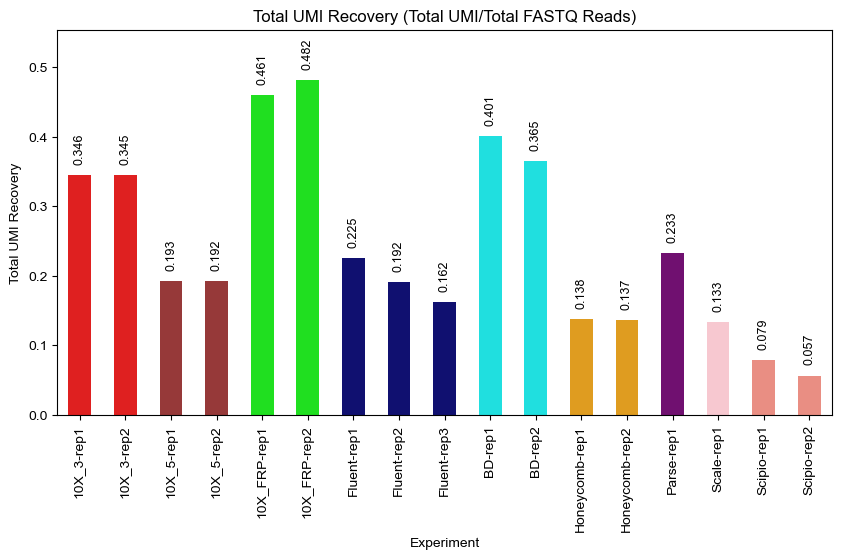

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

##Create Barplot for Mean Sequencing Efficiency/UMI Recovery 
sns.barplot(x="method", y='total_umi_recovery', data=all_summary_df, color = 'lightblue', ax=ax, width = 0.5, 
            palette=colors_platform, order=plotting_order)
ax.set_xlabel("Experiment")
ax.set_ylabel('Total UMI Recovery')
ax.set_title('Total UMI Recovery (Total UMI/Total FASTQ Reads)')
ax.tick_params(axis='x', labelrotation = 90)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


# Annotate bars with values
heights = [] ##initialize list of heights to be used to set limit
for j, p in enumerate(ax.patches):
    heights.append(p.get_height() * 1.15)
    value_format = np.round(p.get_height(), 3)
    ax.annotate(value_format, 
                     (p.get_x() + p.get_width() / 2., p.get_height()+0.02), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontsize=9, 
                     rotation=90)
    
##adjust limits to the max of the heihgts
ax.set_ylim([0, np.nanmax(np.array(heights)[np.isfinite(heights)])])

plt.show()

Let's also look at purely mapped read recovery

/local/42034600/ipykernel_23265/2595134991.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="method", y='mapped_umi_recovery', data=all_summary_df, color = 'lightblue', ax=ax, width = 0.5,


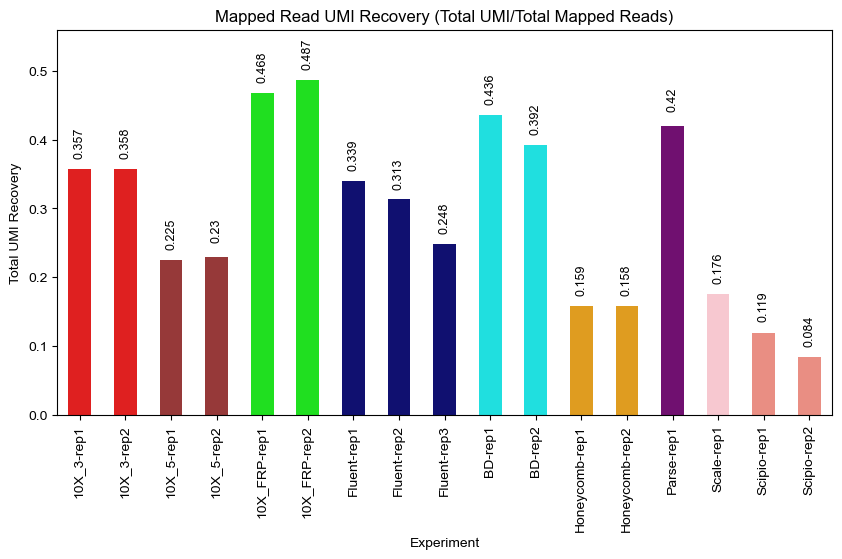

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

##Create Barplot for Mean Sequencing Efficiency/UMI Recovery 
sns.barplot(x="method", y='mapped_umi_recovery', data=all_summary_df, color = 'lightblue', ax=ax, width = 0.5, 
            palette=colors_platform, order=plotting_order)
ax.set_xlabel("Experiment")
ax.set_ylabel('Total UMI Recovery')
ax.set_title('Mapped Read UMI Recovery (Total UMI/Total Mapped Reads)')
ax.tick_params(axis='x', labelrotation = 90)


# Annotate bars with values
heights = [] ##initialize list of heights to be used to set limit
for j, p in enumerate(ax.patches):
    heights.append(p.get_height() * 1.15)
    value_format = np.round(p.get_height(), 3)
    ax.annotate(value_format, 
                     (p.get_x() + p.get_width() / 2., p.get_height()+0.02), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontsize=9, 
                     rotation=90)
    
##adjust limits to the max of the heihgts
ax.set_ylim([0, np.nanmax(np.array(heights)[np.isfinite(heights)])])

plt.show()

Let's also look at recovery for only filtered cells

/local/42034600/ipykernel_23265/204217203.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="method", y='total_umi_recovery', data=fil_summary_df, color = 'lightblue', ax=ax, width = 0.5,


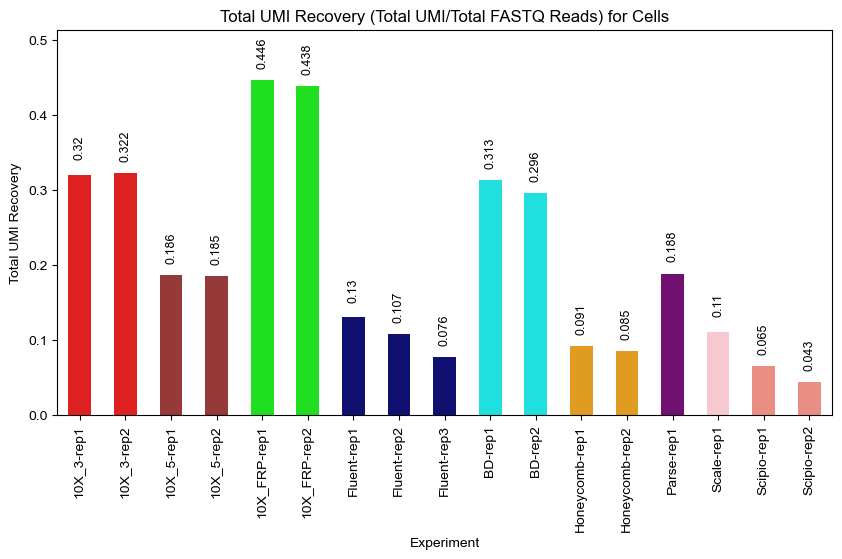

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

##Create Barplot for Mean Sequencing Efficiency/UMI Recovery 
sns.barplot(x="method", y='total_umi_recovery', data=fil_summary_df, color = 'lightblue', ax=ax, width = 0.5, 
            palette = colors_platform, order=plotting_order)
ax.set_xlabel("Experiment")
ax.set_ylabel('Total UMI Recovery')
ax.set_title('Total UMI Recovery (Total UMI/Total FASTQ Reads) for Cells')
ax.tick_params(axis='x', labelrotation = 90)


# Annotate bars with values
heights = [] ##initialize list of heights to be used to set limit
for j, p in enumerate(ax.patches):
    heights.append(p.get_height() * 1.15)
    value_format = np.round(p.get_height(), 3)
    ax.annotate(value_format, 
                     (p.get_x() + p.get_width() / 2., p.get_height()+0.02), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontsize=9, 
                     rotation=90)
    
##adjust limits to the max of the heihgts
ax.set_ylim([0, np.nanmax(np.array(heights)[np.isfinite(heights)])])

plt.show()

/local/42034600/ipykernel_23265/4218540873.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="method", y='mapped_umi_recovery', data=fil_summary_df, color = 'lightblue', ax=ax, width = 0.5,


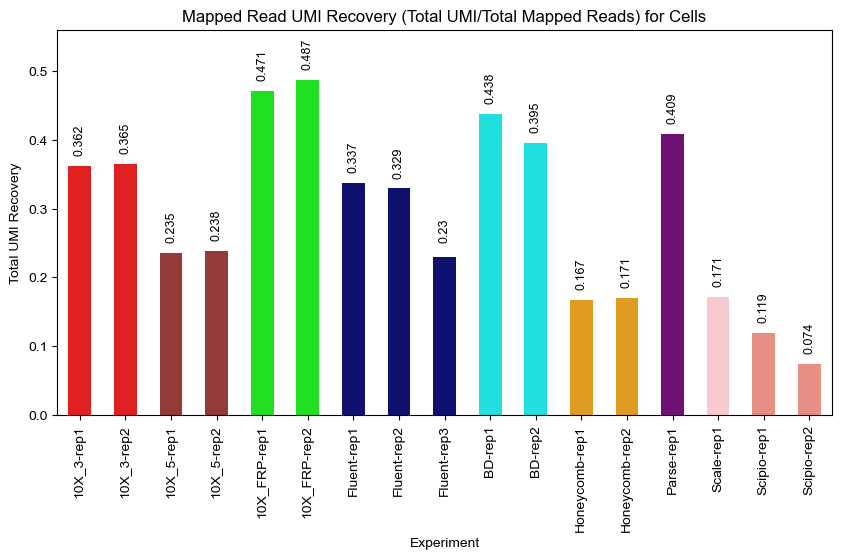

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

##Create Barplot for Mean Sequencing Efficiency/UMI Recovery 
sns.barplot(x="method", y='mapped_umi_recovery', data=fil_summary_df, color = 'lightblue', ax=ax, width = 0.5, 
            palette = colors_platform, order=plotting_order)
ax.set_xlabel("Experiment")
ax.set_ylabel('Total UMI Recovery')
ax.set_title('Mapped Read UMI Recovery (Total UMI/Total Mapped Reads) for Cells')
ax.tick_params(axis='x', labelrotation = 90)


# Annotate bars with values
heights = [] ##initialize list of heights to be used to set limit
for j, p in enumerate(ax.patches):
    heights.append(p.get_height() * 1.15)
    value_format = np.round(p.get_height(), 3)
    ax.annotate(value_format, 
                     (p.get_x() + p.get_width() / 2., p.get_height()+0.02), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontsize=9, 
                     rotation=90)
    
##adjust limits to the max of the heihgts
ax.set_ylim([0, np.nanmax(np.array(heights)[np.isfinite(heights)])])

plt.show()

Let's break up the total UMI recovery per cell into tiers using a kernel density estimator. First we will find the average per platform , then we will plot histogram to understand where grouping might occur, then we will perform grouping

/local/42034600/ipykernel_23265/2306287918.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umi_recovery_cells['platform'] = umi_recovery_cells['method'].str.split('-', expand=True)[0]


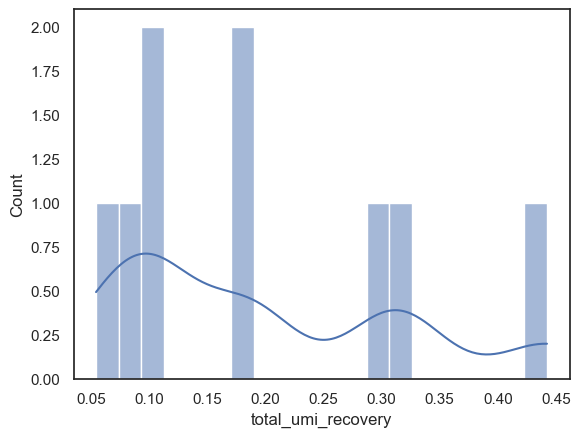

In [24]:
sns.set(style='white')

##first group by platform, get mean, and sort by ascending value
umi_recovery_cells = fil_summary_df[['method', 'total_umi_recovery']]
umi_recovery_cells['platform'] = umi_recovery_cells['method'].str.split('-', expand=True)[0]
umi_recovery_cells = umi_recovery_cells.groupby('platform')['total_umi_recovery'].mean().sort_values(ascending=True)

##plot histogram with a kde on top
fig, ax = plt.subplots(1,1)
sns.histplot(umi_recovery_cells, bins=20, kde=True, kde_kws={'bw_method':0.3}, ax=ax)
plt.show()

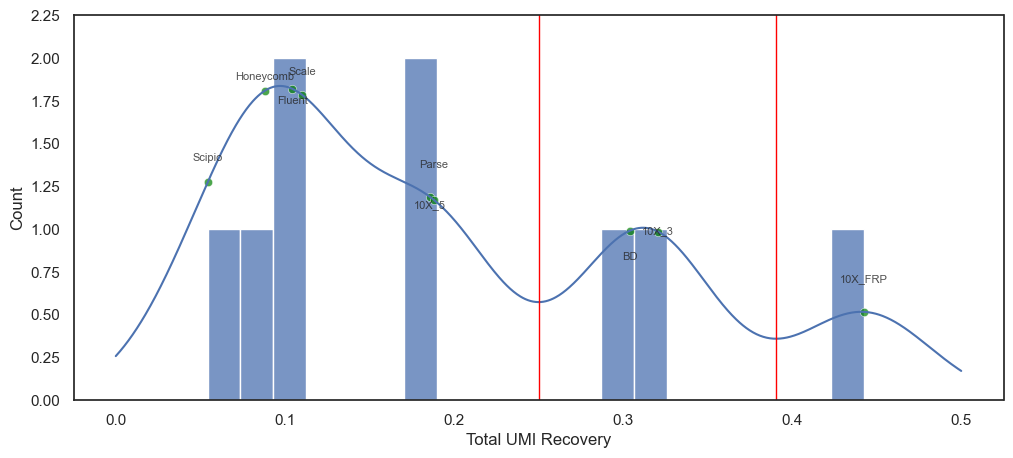

In [25]:
##fit kernel density estimator
bw_method=0.3 ##manually selected to give relatively smooth curve
X_range = np.linspace(0,0.5, 1000) #X values on range of 0 to 0.5 based on histogram above
kernel = gaussian_kde(umi_recovery_cells, bw_method=bw_method, weights=None) #define kde with bw_method
fitted_dens = kernel.evaluate(X_range) #get density
predicted_dens = kernel.evaluate(umi_recovery_cells)
ordered_labels = umi_recovery_cells.index

##scale density to get onto scale of histogram
fitted_dens = fitted_dens *0.45
predicted_dens = predicted_dens*0.45

 ##Calculate the negative density values so we can find minima by finding peaks of the negative density
neg_dens = -fitted_dens

##Use find_peaks to get estimates for local minima (finds peaks of negative, which are minima in orig)
with ignore_warnings(category=ConvergenceWarning):
    minima_indices, _ = find_peaks(neg_dens)

##get thresholds
umi_recovery_thresholds = X_range[minima_indices]

##plot split with points and thresholds
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(X_range, fitted_dens)
sns.histplot(umi_recovery_cells, bins=20, ax=ax)
sns.scatterplot(x=umi_recovery_cells, y=predicted_dens, color='green',  alpha=0.7, ax=ax)

##Add threshold lines
[ax.axvline(_x, linewidth=1, color="red", linestyle="-") for _x in umi_recovery_thresholds]

##Adding labels

np.random.seed(46)
y_jitter = (np.random.rand(len(umi_recovery_cells))-0.5)/2.5  # get jitter in range 
for i, txt in enumerate(ordered_labels):
    ax.annotate(txt, ((umi_recovery_cells[i]), (predicted_dens[i]+y_jitter[i])), alpha=0.8, ha='center', va='bottom', fontsize=8) ##add vertical jitter
    
##Format Axes
ax.set_xlabel('Total UMI Recovery')
ax.set_ylim([None, 2.25])
    
plt.show()

In [26]:
##get groups now that we have thresholds (lower group if <= higher group if >)
umi_recovery_thresholds = np.sort(umi_recovery_thresholds) ##make sure it is ascending so first is lower one
tiers = { 
    "tier_1": umi_recovery_cells[umi_recovery_cells > umi_recovery_thresholds[1]].index.to_list(),
    "tier_2": umi_recovery_cells[(umi_recovery_cells > umi_recovery_thresholds[0]) & (umi_recovery_cells <= umi_recovery_thresholds[1])].index.to_list(),
    "tier_3": umi_recovery_cells[umi_recovery_cells <= umi_recovery_thresholds[0]].index.to_list()
}
tiers

{'tier_1': ['10X_FRP'],
 'tier_2': ['BD', '10X_3'],
 'tier_3': ['Scipio', 'Honeycomb', 'Fluent', 'Scale', '10X_5', 'Parse']}

check to make sure the groupings make sense

In [27]:
##save as table
umi_recovery_file = os.path.join(supplement_table_dir, 'Table5_UMI_Recovery_agg.csv')
pd.DataFrame(umi_recovery_cells).to_csv(umi_recovery_file, index=True)
pd.DataFrame(umi_recovery_cells)

,total_umi_recovery
platform,
Scipio,0.054320
Honeycomb,0.088146
Fluent,0.104514
Scale,0.110105
10X_5,0.185707
Parse,0.188089
BD,0.304093
10X_3,0.320607
10X_FRP,0.442232


They do. 10X FRP stands off by itself and BD and 10X 3' are a separate, but high group. The rest also mostly cluster together, you could probably put 10X5 and Parse together, but we are aiming for three tiers

In [28]:
fil_summary_df[['method', 'total_umi_recovery']].sort_values('total_umi_recovery')

,method,total_umi_recovery
16,Scipio-rep2,0.043221
15,Scipio-rep1,0.065419
10,Fluent-rep3,0.076438
12,Honeycomb-rep2,0.084792
11,Honeycomb-rep1,0.091499
9,Fluent-rep2,0.107315
14,Scale-rep1,0.110105
8,Fluent-rep1,0.129789
3,10X_5-rep2,0.185245
2,10X_5-rep1,0.186170


### <center> On Target Sequencing and Mapping Rates (Read Breakdown Plot)

/local/42034600/ipykernel_23265/2192209654.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = ax.yaxis.get_ticklabels(), fontsize=20)


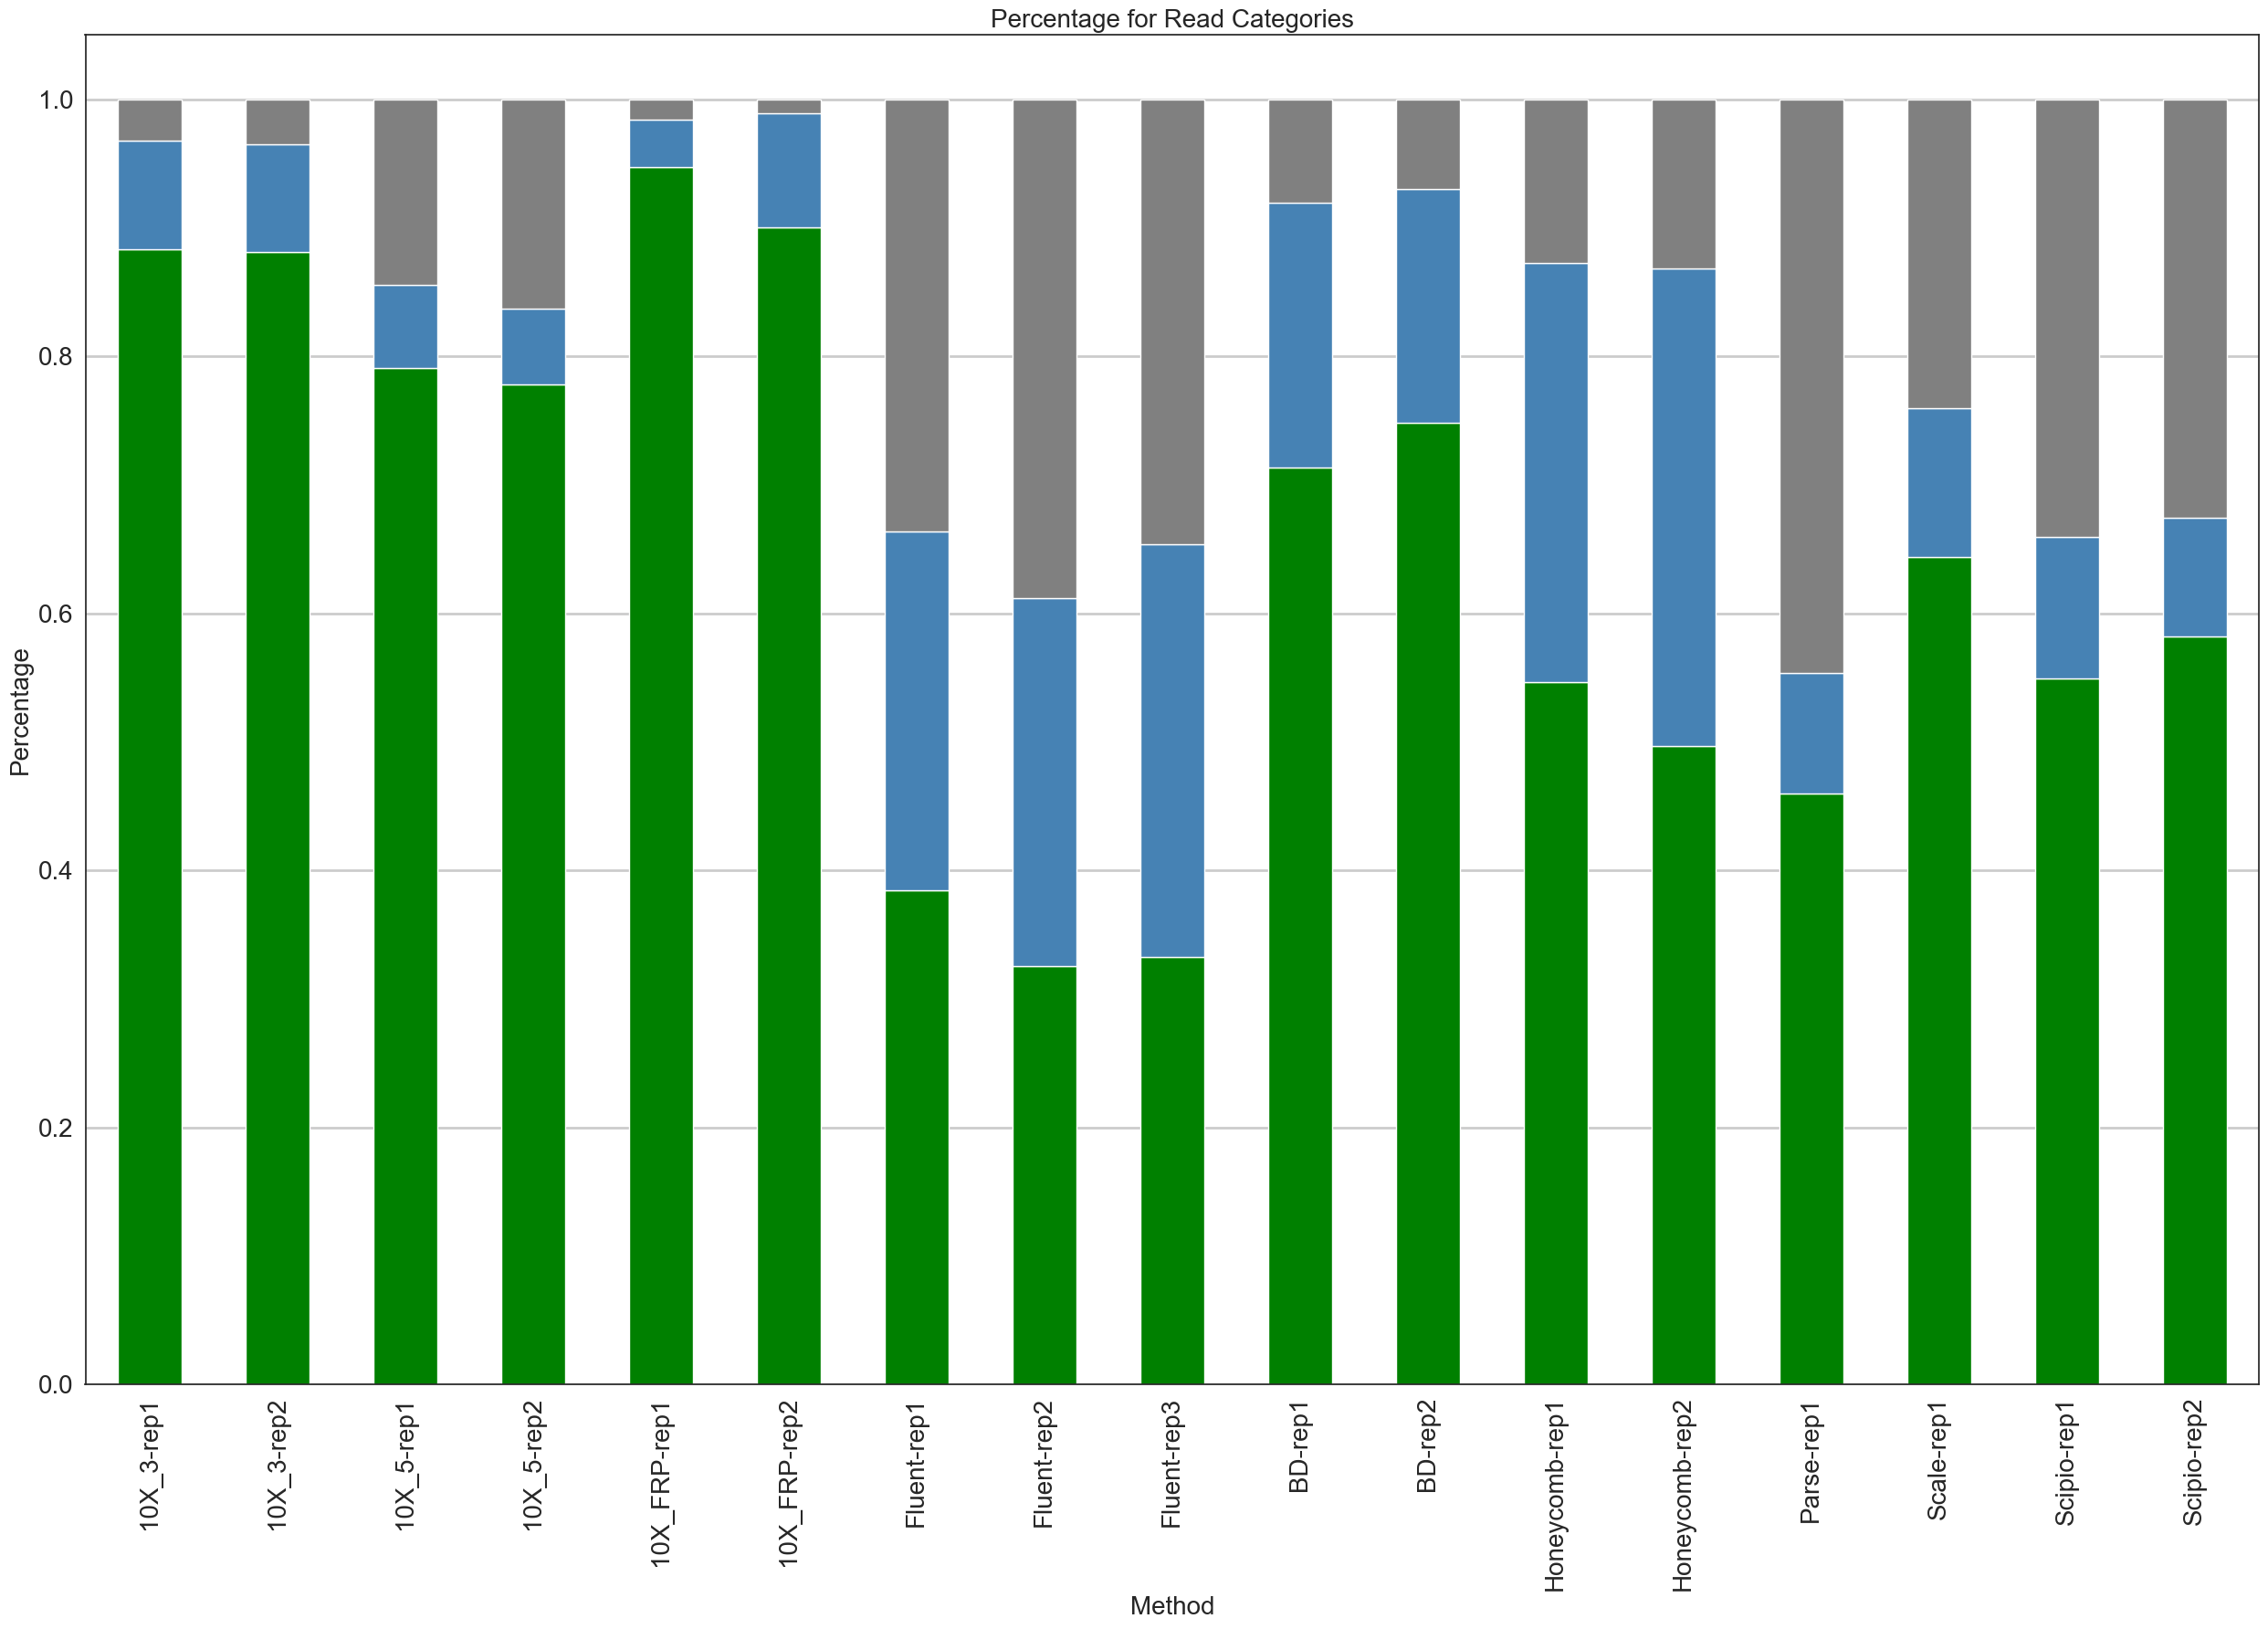

In [29]:
##create a dataframe containing the proportion of reads going to each category
##the categories are A) On-target mapped reads B) Off-target mapped reads C) Unmapped/Lost Reads

on_target_mapped=fil_summary_df['total_mapped_reads']/all_summary_df['fastq_readcounts'] ## could also have divided by fil_summary_df['fastq_readcounts'] since it is the same number, but this is clearer
mapped=all_summary_df['total_mapped_reads']/all_summary_df['fastq_readcounts']
off_target_mapped=mapped-on_target_mapped
unmapped=1-mapped

##We NOW have bam files

##create df
df_read_summary = pd.DataFrame({'method': all_summary_df['method'],
                                'on_target_mapped': on_target_mapped, 'off_target_mapped': off_target_mapped,
                                'unmapped/lost': unmapped
                    })



#set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart ordered according to plotting order
df_read_summary = df_read_summary.set_index('method').loc[plotting_order, :]
ax = df_read_summary.plot(kind='bar', stacked=True, color=['green', 'steelblue', 'grey'], figsize=(25, 18)) ##scaled to match size in  final image 

##add labels and annotations
ax.grid(axis='y', linewidth=2)
ax.set_xlabel('Method', size=20)
ax.set_ylabel('Percentage', size=20)
ax.set_title('Percentage for Read Categories', size=20)
ax.set_xticklabels(labels = ax.xaxis.get_ticklabels(), fontsize=20)
ax.set_yticklabels(labels = ax.yaxis.get_ticklabels(), fontsize=20)
    
##move legend outside plot
labels=['In-Cell Mapped & Tagged', 'Out-of-Cell Mapped & Tagged', 'Unmapped/Untagged/Lost']
# ax.legend(labels, title="Read Categories", loc='upper right', bbox_to_anchor=(1.2, 1.01), prop={'size': 11.5})
# ax.legend(labels, title='Read Categories', loc='lower center', bbox_to_anchor=(0.5,-0.18), ncol = 3, prop={'size': 14})
ax.get_legend().remove()

##convert mm width to inches so we can specify height in inches

##define plot layout and show
plt.tight_layout()
plt.show()

In [31]:
df_read_summary.sort_values('on_target_mapped', ascending=False)

,on_target_mapped,off_target_mapped,unmapped/lost
method,,,
10X_FRP-rep1,0.947023,0.037045,0.015932
10X_FRP-rep2,0.900279,0.089236,0.010484
10X_3-rep1,0.883098,0.084899,0.032002
10X_3-rep2,0.881074,0.083661,0.035265
10X_5-rep1,0.791336,0.064008,0.144655
10X_5-rep2,0.778027,0.059009,0.162965
BD-rep2,0.748107,0.181981,0.069912
BD-rep1,0.713810,0.205526,0.080664
Scale-rep1,0.644009,0.115876,0.240115


In [32]:
df_read_summary['on_target_mapped'] + df_read_summary['off_target_mapped']

method
10X_3-rep1        0.967998
10X_3-rep2        0.964735
10X_5-rep1        0.855345
10X_5-rep2        0.837035
10X_FRP-rep1      0.984068
10X_FRP-rep2      0.989516
Fluent-rep1       0.663910
Fluent-rep2       0.611705
Fluent-rep3       0.653898
BD-rep1           0.919336
BD-rep2           0.930088
Honeycomb-rep1    0.872998
Honeycomb-rep2    0.868725
Parse-rep1        0.553763
Scale-rep1        0.759885
Scipio-rep1       0.659209
Scipio-rep2       0.674496
dtype: float64

let's look at mean values per platform

In [33]:
mean_read_summary = df_read_summary.copy()
mean_read_summary=mean_read_summary.reset_index()
mean_read_summary['platform'] = mean_read_summary['method'].str.split('-', expand=True)[0]
mean_read_summary = mean_read_summary.groupby('platform').mean(numeric_only=True)
mean_read_summary

,on_target_mapped,off_target_mapped,unmapped/lost
platform,,,
10X_3,0.882086,0.084280,0.033634
10X_5,0.784682,0.061509,0.153810
10X_FRP,0.923651,0.063141,0.013208
BD,0.730958,0.193754,0.075288
Fluent,0.347686,0.295485,0.356829
Honeycomb,0.521644,0.349218,0.129138
Parse,0.459822,0.093942,0.446237
Scale,0.644009,0.115876,0.240115
Scipio,0.565586,0.101267,0.333148


Lastly, let's look at the steps where reads are lost by plotting mean reads per cell, mean mapped reads per cell, and mean umis per cell as a line plot. 

In [35]:
fil_summary_df

,method,n_cells_internal,mean_depth,median_depth,mean_umi_count,median_umi_count,mean_umi_pct,median_umi_pct,total_mapped_reads,total_umis,total_umis_manual,experiment,fastq_readcounts,n_cells_target,n_cells_loaded,total_umi_recovery,mapped_umi_recovery
0,10X_3-rep1,8453,26806.364486,24754.0,9702.407784,9052.0,0.361225,0.362889,226594199,82014453.0,82014453.0,10X_3-rep1,256590000,10000,16500,0.319632,0.361944
1,10X_3-rep2,11268,26497.913206,24910.0,9671.427050,9197.0,0.360288,0.365184,298578486,108977640.0,108977640.0,10X_3-rep2,338880000,10000,16500,0.321582,0.364988
2,10X_5-rep1,8455,23905.752927,21580.0,5624.067534,5035.0,0.235649,0.241138,202123141,47551491.0,47551491.0,10X_5-rep1,255420000,10000,16500,0.186170,0.235260
3,10X_5-rep2,8135,23401.051875,21636.0,5571.701291,5036.0,0.239722,0.244738,190367557,45325790.0,45325790.0,10X_5-rep2,244680000,10000,16500,0.185245,0.238096
4,10X_FRP-rep1,10316,28496.079779,28954.5,13422.037127,13765.0,0.473158,0.469208,293965559,138461735.0,138461735.0,10X_FRP-rep1,310410000,10000,16500,0.446061,0.471013
5,10X_FRP-rep2,8048,27119.125994,28116.5,13206.049205,13876.5,0.489831,0.485703,218254726,106282284.0,106282284.0,10X_FRP-rep2,242430000,10000,16500,0.438404,0.486964
6,BD-rep1,11333,21431.300185,20864.0,9387.272214,9236.0,0.439418,0.441970,242880925,106385956.0,106385956.0,BD-rep1,340260000,20000,27200,0.312661,0.438017
7,BD-rep2,16841,22433.869188,22167.0,8862.083487,8886.0,0.394821,0.399435,377808791,149246348.0,149246348.0,BD-rep2,505020000,20000,27200,0.295526,0.395031
8,Fluent-rep1,11333,11000.735728,8687.0,3711.928174,3148.0,0.382781,0.363199,124671338,42067282.0,42067282.0,Fluent-rep1,324120000,10000,21230,0.129789,0.337425
9,Fluent-rep2,10306,9119.883757,5127.0,3003.272657,2077.0,0.391037,0.398140,93989522,30951728.0,30951728.0,Fluent-rep2,288420000,10000,22800,0.107315,0.329310


/local/42034600/ipykernel_23265/3127532289.py:16: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  scatter = sns.pointplot(data=df_long, x='variable', y='value', hue='method', palette=colors_platform, join=True, scale=0.5)
/local/42034600/ipykernel_23265/3127532289.py:16: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  scatter = sns.pointplot(data=df_long, x='variable', y='value', hue='method', palette=colors_platform, join=True, scale=0.5)
/local/42034600/ipykernel_23265/3127532289.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter.set_xticklabels(new_labels)


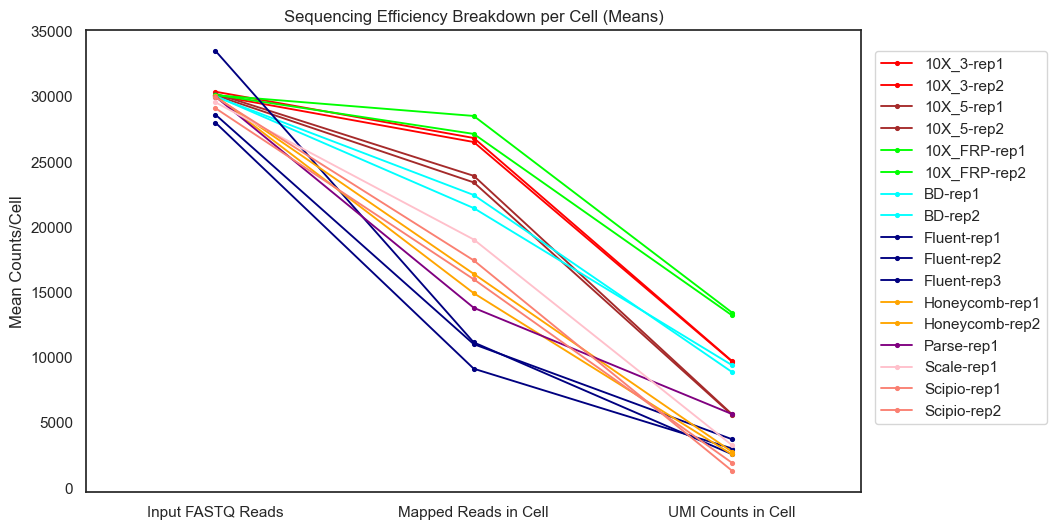

In [36]:
##Calculate per cell summary stats
fil_summary_df = fil_summary_df.assign(fastq_per_cell = lambda dataframe: dataframe['fastq_readcounts'] / dataframe['n_cells_internal'],
                                       mapped_per_cell = lambda dataframe: dataframe['total_mapped_reads'] / dataframe['n_cells_internal'],
                                       umi_per_cell = lambda dataframe: dataframe['total_umis'] / dataframe['n_cells_internal']
                                      )

##Melt the dataframe into long format for plotting
df_long = fil_summary_df.melt(id_vars='method', value_vars=['fastq_per_cell', 'mapped_per_cell', 'umi_per_cell'])

##Turn data to categorical and order so we plot in the correct order
df_long['variable'] = pd.Categorical(df_long['variable'], categories=['fastq_per_cell', 'mapped_per_cell', 'umi_per_cell'], ordered=True)


##Plot so that fastq, mapped, and umi are on x-axis in the order specified
plt.figure(figsize=(10,6))
scatter = sns.pointplot(data=df_long, x='variable', y='value', hue='method', palette=colors_platform, join=True, scale=0.5)
scatter.legend(loc='center right', bbox_to_anchor=(1.25, 0.55), ncol=1)
scatter.set(xlabel = None, ylabel = 'Mean Counts/Cell')

##Changing x-axis tick labels
new_labels = ["Input FASTQ Reads", "Mapped Reads in Cell", "UMI Counts in Cell"]
scatter.set_xticklabels(new_labels)

##Give the plot a title
plt.title('Sequencing Efficiency Breakdown per Cell (Means)')

plt.show()